In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import sys

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import spatial
import time
import scipy.linalg
import healpy as hp

sys.path.insert(0,"/home/deparis/jupyter/pyemma/")
from pyemma import *
%cd "~/Emma"

%load_ext autoreload
%autoreload 2
%connect_info

/home/deparis/Emma
/home/deparis/Emma
{
  "signature_scheme": "hmac-sha256",
  "ip": "127.0.0.1",
  "shell_port": 49589,
  "iopub_port": 43172,
  "stdin_port": 40811,
  "hb_port": 51342,
  "transport": "tcp",
  "key": "685452dd-e9d1-49a3-bc65-396fd1914bf6",
  "control_port": 60190
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing /run/user/1003/jupyter/kernel-660e4dce-2003-4881-a4f0-8ac5a35b8cc2.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
import matplotlib
matplotlib.rc('font', **font)

In [3]:
runset=db.Runset()
runset.load()
runset.get_description()
runset.get_folder()

00 run de base -> m2
01 masse d'etoile *8 -> m1
02 même masse d'étoile mais pas de SN
03 masse d'etoile *8 mais pas de SN
04 masse d'étoile /8 -> m3
05 même masse d'étoile mais SN thermique
06 même masse d'étoile mais SN kin simple sans eject
07 même masse d'étoile mais SN kin simple avec eject
08 même masse d'étoile mais sans tirage de Poisson __ DOUTE
09 tout pareil mais avec flux __ PROBLEME
10 RERUN tout pareil mais avec flux
11 run de test
12 run de test avec contrainte sur la fraction d'ionisation au niveau des source
00 /home/deparis/curie_data/data/8_8_gather_6/
01 /home/deparis/curie_data/data/8_8_gather_7/
02 /home/deparis/curie_data/data/8_8_gather_8/
03 /home/deparis/curie_data/data/8_8_gather_9/
04 /home/deparis/curie_data/data/8_8_gather_10/
05 /home/deparis/curie_data/data/8_8_gather_11/
06 /home/deparis/curie_data/data/8_8_gather_12/
07 /home/deparis/curie_data/data/8_8_gather_13/
08 /home/deparis/curie_data/data/8_8_gather_14/
09 /home/deparis/curie_data/data/8_8_gathe

In [5]:
run1=io.Run(runset.runs[1].folder)
run2=io.Run(runset.runs[10].folder)
run3=io.Run(runset.runs[4].folder)

In [150]:
step1 = run1.step_00015
step2 = run2.step_00017
step3 = run3.step_00019

In [151]:
step1.fof.get_star(step1.star)
step1.fof.get_luminosity_1600(step1)

step2.fof.get_star(step2.star)
step2.fof.get_luminosity_1600(step2)

step3.fof.get_star(step3.star)
step3.fof.get_luminosity_1600(step3)

Reading /home/deparis/curie_data/data/8_8_gather_7/data/00015/halo/stars
reading star_age
reading star_mass
Getting nfoftot
Reading /home/deparis/curie_data/data/8_8_gather_16/data/00017/halo/stars
reading star_age
reading star_mass
Getting nfoftot
Reading /home/deparis/curie_data/data/8_8_gather_10/data/00019/halo/stars
reading star_age
reading star_mass
Getting nfoftot


<IPython.core.display.Javascript object>


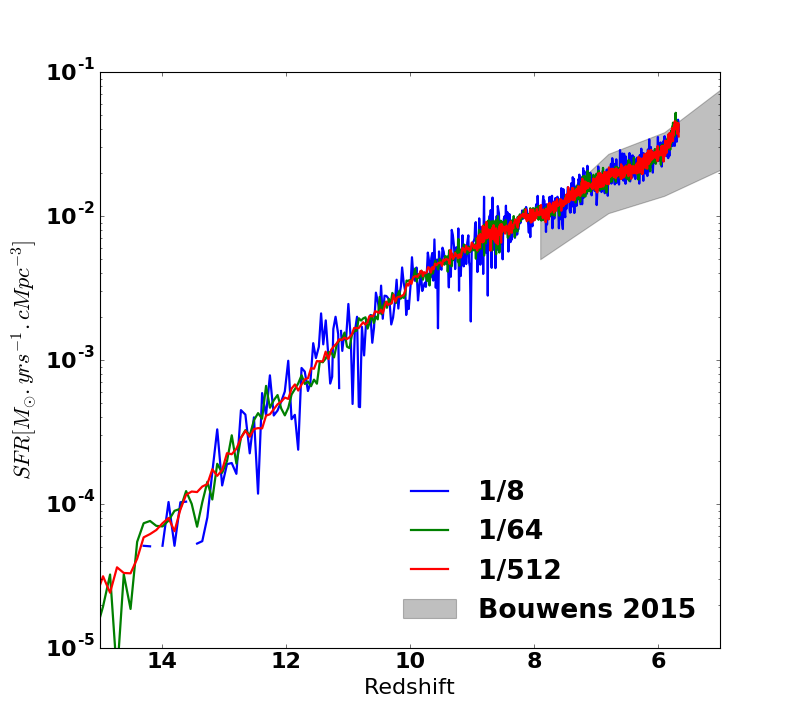

(1e-05, 0.1)

In [421]:
z1,sfr1=clean_sfr_restart(run1.param.avg.z,run1.param.avg.SFR)
z2,sfr2=clean_sfr_restart(run2.param.avg.z,run2.param.avg.SFR)
z3,sfr3=clean_sfr_restart(run3.param.avg.z,run3.param.avg.SFR)


fig=plt.figure(figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)

plt.plot(z1[:-1],sfr1[:-1],lw=2, label="1/8")
plt.plot(z2,sfr2,lw=2, label="1/64")
plt.plot(z3,sfr3,lw=2, label="1/512")

x,y,_,z=observations.sfr1()
# plt.errorbar(x,y,yerr=z,fmt='ko',markersize=10)

arg=np.argsort(x)
x=x[arg][1::2]
y=y[arg][1::2]
zmin=z[0][arg][1::2]
zmax=z[1][arg][1::2]
plt.fill_between(x, y-zmin, y+zmax,  facecolor='k', alpha=0.25, label="Bouwens 2015")

x,y,_,z=observations.sfr2()
# plt.errorbar(x,y,yerr=z,fmt='ko',markersize=10)

# arg=np.argsort(x)
# x=x[arg][::1]
# y=y[arg][::1]
# zmin=z[0][arg][::1]
# zmax=z[1][arg][::1]
# plt.fill_between(x, y-zmin, y+zmax,facecolor='blue', alpha=0.5)


plt.legend(frameon=False, loc= 4)
plt.yscale("log", nonposy='mask')
plt.xlabel('Redshift')
plt.ylabel('$ SFR [ M_{\\odot}.yrs^{-1}.cMpc^{-3} ]$')

plt.xlim(15,5)
plt.ylim(1e-5,1e-1)


In [23]:
def clean_sfr_restart(z,sfr):

    restart=1
    zrestart=100000

    z_clean=np.array([])
    sfr_clean=np.array([])

    for i,curz in enumerate(z[1:]):

        if (curz<zrestart):
            restart=0

        if (curz-z[i-1]>0) and not restart:
            restart=1
            zrestart=curz

        if not restart:
            z_clean=np.append(z_clean,curz)
            sfr_clean=np.append(sfr_clean,sfr[i])
    return z_clean,sfr_clean

In [270]:
z

[array([ 0.00537913,  0.00324125,  0.00204509,  0.00155136,  0.00075982,
         0.06369219,  0.03307647,  0.01437999,  0.00994609,  0.00330577]),
 array([ 0.00617607,  0.00372145,  0.00234808,  0.0017812 ,  0.00102987,
         0.05213699,  0.02611377,  0.00998682,  0.00661354,  0.00139933])]

<IPython.core.display.Javascript object>


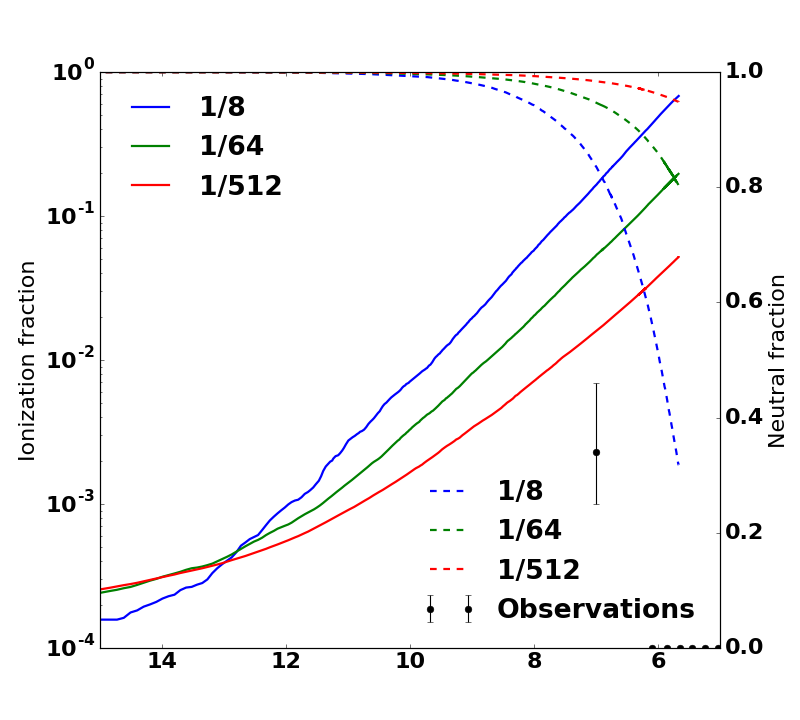

(15, 5)

In [7]:
z1=run1.param.avg.z
x1=run1.param.avg.xion.mean

z2=run2.param.avg.z
x2=run2.param.avg.xion.mean

z3=run3.param.avg.z
x3=run3.param.avg.xion.mean

fig,ax1=plt.subplots(1,sharex=True, figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)

ax2=ax1.twinx()
ax1.invert_xaxis()

ax1.plot(z1,x1,lw=2, c='b', label="1/8")
ax2.plot(z1,1-x1,lw=2, c='b', ls='--', label="1/8")

ax1.plot(z2,x2,lw=2, c='g', label="1/64")
ax2.plot(z2,1-x2,lw=2, c='g', ls='--', label="1/64")

ax1.plot(z3,x3,lw=2, c='r', label="1/512")
ax2.plot(z3,1-x3,lw=2, c='r', ls='--', label="1/512")

observations.xion()

ax1.legend(loc=0,frameon=False)
ax1.set_yscale("log")
ax1.set_ylabel('Ionization fraction')
ax1.set_ylim(1e-4,1e0)

ax2.legend(loc=4,frameon=False)
# ax2.set_yscale("log")
ax2.set_ylim(0,1e0)
ax2.set_ylabel('Neutral fraction')

plt.xlabel('Redshift')
plt.xlim(15,5)

<IPython.core.display.Javascript object>


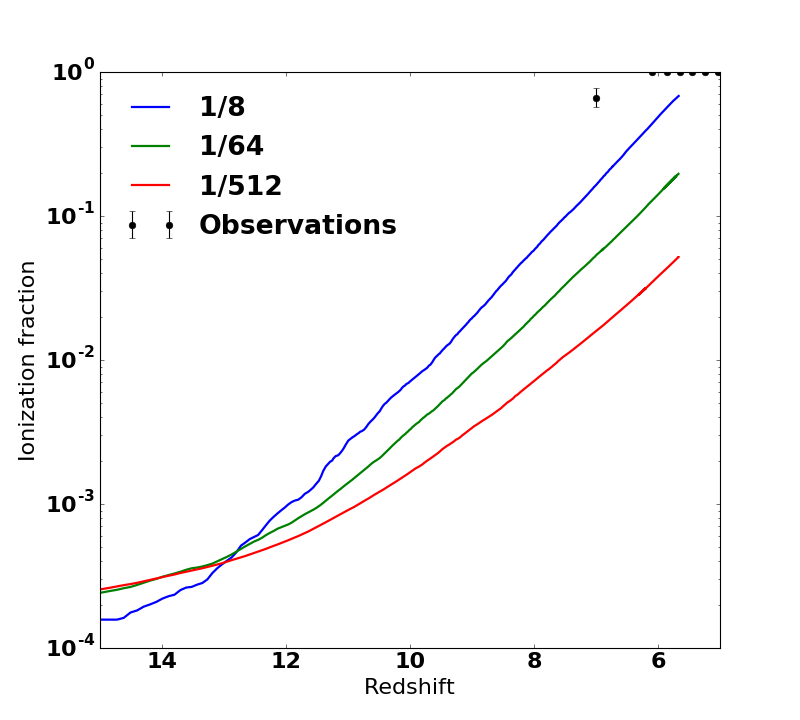

(15, 5)

In [9]:
z1=run1.param.avg.z
x1=run1.param.avg.xion.mean

z2=run2.param.avg.z
x2=run2.param.avg.xion.mean

z3=run3.param.avg.z
x3=run3.param.avg.xion.mean

fig,ax1=plt.subplots(1,sharex=True, figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)


ax1.invert_xaxis()

ax1.plot(z1,x1,lw=2, c='b', label="1/8")
ax1.plot(z2,x2,lw=2, c='g', label="1/64")
ax1.plot(z3,x3,lw=2, c='r', label="1/512")



z=np.array([

[5.03, 0.9999451, 0.0000142, -0.0000165],
[5.25, 0.9999330, 0.0000207, -0.0000244],
[5.45, 0.9999333, 0.0000247, -0.0000301],
[5.65, 0.9999140, 0.0000365, -0.0000460],
[5.85, 0.9998800, 0.0000408, -0.0000490],
[6.10, 0.99957  , 0.00030  , -0.00030  ],
[7.0 , 0.66     , 0.12     , -0.09 	   ]
])

x=z[:,0]
y=z[:,1]

yerror = [-z[:,3], z[:,2]]

ax1.errorbar(x, y, xerr=None, yerr=yerror, ls='none', fmt='ko', label="Observations")		

ax1.legend(loc=0,frameon=False)
ax1.set_yscale("log")
ax1.set_ylabel('Ionization fraction')
ax1.set_ylim(1e-4,1e0)

ax2.legend(loc=4,frameon=False)
# ax2.set_yscale("log")
ax2.set_ylim(0,1e0)
ax2.set_ylabel('Neutral fraction')

plt.xlabel('Redshift')
plt.xlim(15,5)

<IPython.core.display.Javascript object>


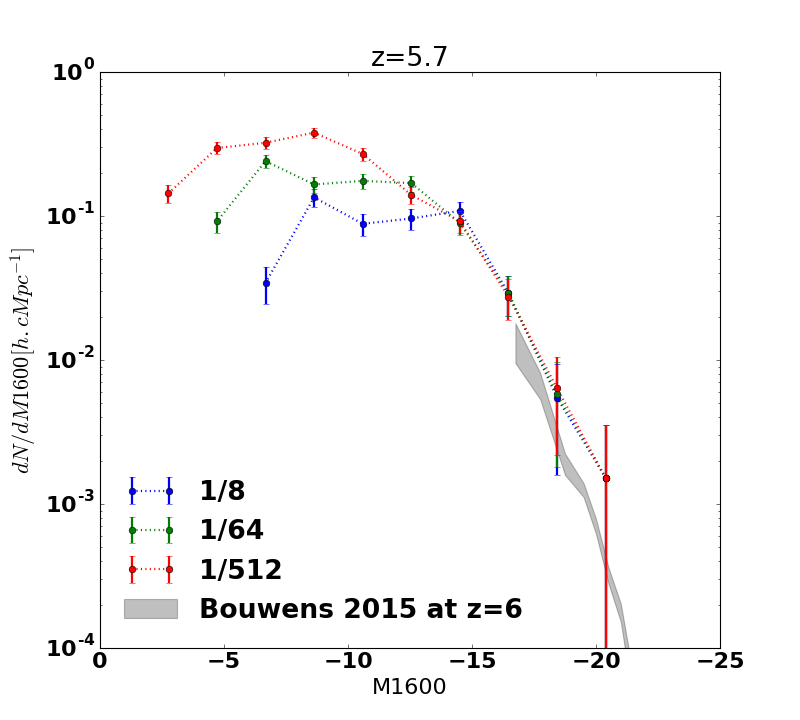

In [466]:
fig, ax=plt.subplots(1,figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)

cur_step=run3.step_00021
cur_step.fof.get_luminosity_1600(run3.step_00021)

nbins=10
bins=np.linspace(np.min(cur_step.fof.mag_1600),np.max(cur_step.fof.mag_1600),nbins+1)
# bins=np.linspace(-25,0,nbins+1)
_x=(bins[1:]+bins[:-1])/2
dx=np.diff(bins)

box_V=(run1.param.info.box_size_hm1_Mpc/(run1.param.info.H0/100))**3

label=["1/8","1/64","1/512"]
for i,cur_step in enumerate([run1.step_00017, run2.step_00017, run3.step_00021]):
    
#     cur_step.fof.get_luminosity_1600(cur_step)
    n,_=np.histogram(cur_step.fof.mag_1600,bins=bins)
    
    ax.errorbar(_x[n>0], n[n>0]/dx[n>0]/box_V, yerr=3.*np.sqrt(n[n>0])/dx[n>0]/box_V,fmt='o:',label=label[i],lw=2)


# x,y=observations.luminosity_function_fit(6)
# plt.plot(x,y,'k--', label="z=6 fits")

x,y,z=observations.luminosity_function(6)
# plt.errorbar(x,y,yerr=z,fmt='ko', label="z=6 observations")
ax.fill_between(x, np.subtract(y,z), np.add(y,z),  facecolor='k', alpha=0.25, label="Bouwens 2015 at z=6")

plt.ylim(1e-4,1e-0)
plt.yscale("log")

handles, labels = ax.get_legend_handles_labels()

# reverse the order
order=[0,1,2,3]
# print(labels[0])[order]
tmp=labels[0]
labels[0]=labels[1]
labels[1]=labels[2]
labels[2]=labels[3]
labels[3]=tmp

tmp=handles[0]
handles[0]=handles[1]
handles[1]=handles[2]
handles[2]=handles[3]
handles[3]=tmp

ax.legend(handles, labels, loc=0, frameon=False)

fig.get_axes()[0].invert_xaxis()

plt.title("z=5.7")
plt.xlabel('M1600')
plt.ylabel('$dN/dM1600  [h.cMpc^{-1}]$')

<IPython.core.display.Javascript object>


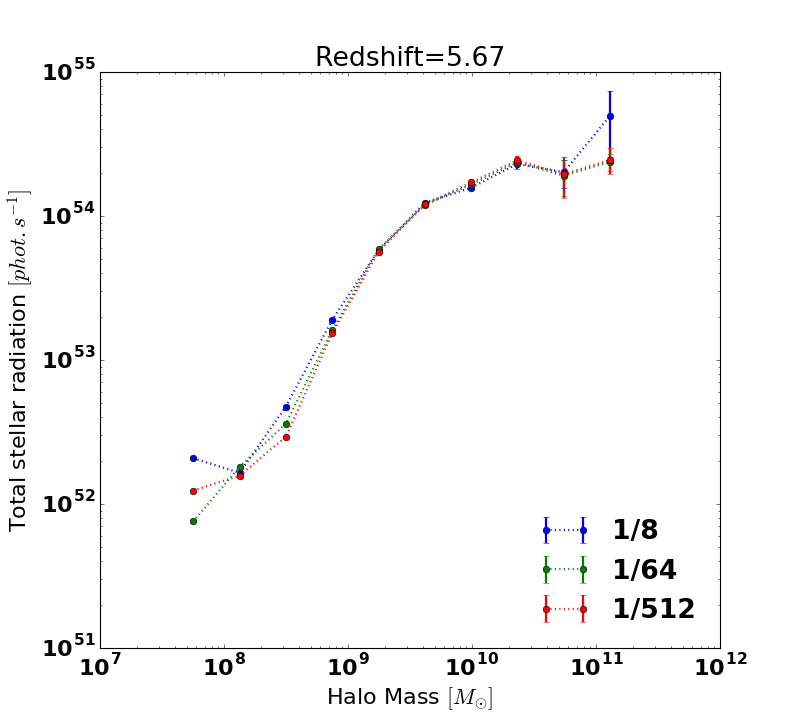

In [483]:
Nbins=10

fig=plt.figure(figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)

cur_step=run1.step_00017
mh=cur_step.fof.part_mass_fine
Mbins=np.logspace(np.log10(np.min(mh)), np.log10(np.max(mh)), Nbins+1)
_x=(Mbins[1:]+Mbins[:-1])/2

label=["1/8","1/64","1/512"]
for i,cur_step in enumerate([run1.step_00017, run2.step_00017, run3.step_00021]):

#     cur_step.fof.get_star(cur_step.star)
#     cur_step.fof.get_luminosity_UV(cur_step)
#     cur_step.fof.get_mean_vel(force=0)
#     cur_step.fof.get_cells(cur_step.grid, force=0)
#         cur_step.fof.get_flux_r200(cur_step.grid, "rad", force=0)
#         cur_step.fof.get_flux_r200(cur_step.grid, "hydro")

    mh=cur_step.fof.part_mass_fine
    w=cur_step.fof.star_flux_UV
    n0,_=np.histogram(mh,bins=Mbins)
    n1,_=np.histogram(mh,bins=Mbins, weights=w)
    n2,_=np.histogram(mh,bins=Mbins, weights=w*w)
    err = np.sqrt(n2/n0 - n1*n1/n0/n0)*3#/np.sqrt(n0) *3
    
    plt.errorbar(_x,n1,yerr=err,fmt='o:',lw=2, label=label[i])

plt.title("Redshift=5.67")
plt.legend(frameon=False, loc=4 )
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass $[M_{\odot}]$')
plt.ylabel(r'Total stellar radiation $[phot.s^{-1}]$')
# plt.ylim(1e46, 1e55)

<IPython.core.display.Javascript object>


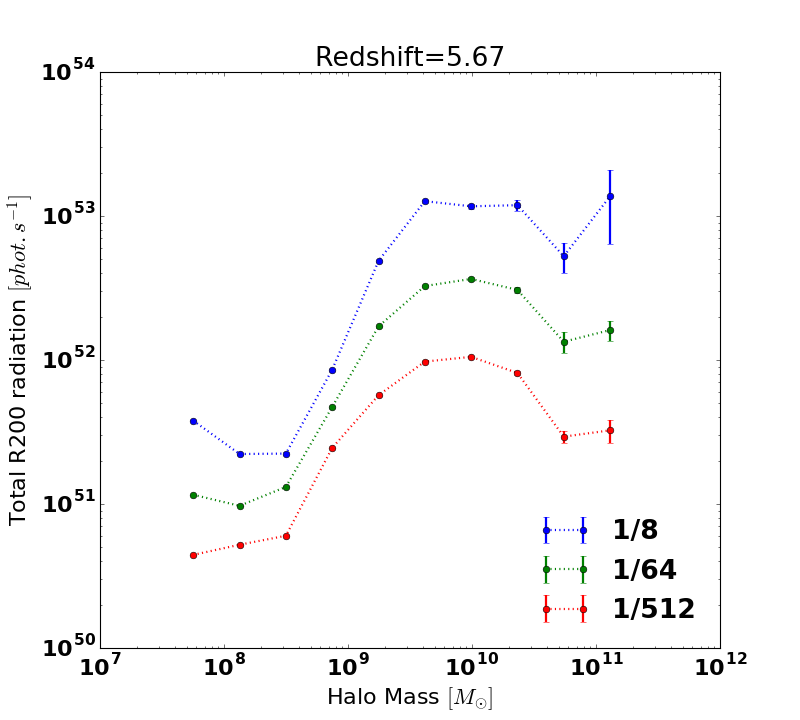

Reading /home/deparis/curie_data/data/8_8_gather_7/data/00017/halo/flux_r200_rad
Reading /home/deparis/curie_data/data/8_8_gather_16/data/00017/halo/flux_r200_rad
Reading /home/deparis/curie_data/data/8_8_gather_10/data/00021/halo/flux_r200_rad


In [482]:
Nbins=10

fig=plt.figure(figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)

cur_step=run1.step_00017
mh=cur_step.fof.part_mass_fine
Mbins=np.logspace(np.log10(np.min(mh)), np.log10(np.max(mh)), Nbins+1)
_x=(Mbins[1:]+Mbins[:-1])/2

info=run1.param.info
fact=(0.15**4)*info.unit_l**2*info.unit_t/(365*24*3600)

label=["1/8","1/64","1/512"]
for i,cur_step in enumerate([run1.step_00017, run2.step_00017, run3.step_00021]):

#     cur_step.fof.get_star(cur_step.star)
#     cur_step.fof.get_luminosity_UV(cur_step)
#     cur_step.fof.get_mean_vel(force=0)
#     cur_step.fof.get_cells(cur_step.grid, force=0)
    cur_step.fof.get_flux_r200(cur_step.grid, "rad", force=0)

    mh=cur_step.fof.part_mass_fine
    w=cur_step.fof.mean_flux_rad_1_00
    n0,_=np.histogram(mh,bins=Mbins)
    n1,_=np.histogram(mh,bins=Mbins, weights=w)
    n2,_=np.histogram(mh,bins=Mbins, weights=w*w)
    err = np.sqrt(n2/n0 - n1*n1/n0/n0)*3 #/np.sqrt(n0) *3
    
    plt.errorbar(_x,n1*fact,yerr=err*fact,fmt='o:',lw=2, label=label[i])
plt.title("Redshift=5.67")
plt.legend(frameon=False, loc=4 )
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass $[M_{\odot}]$')
plt.ylabel(r'Total R200 radiation $[phot.s^{-1}]$')
# plt.ylim(1e46, 1e55)

In [ ]:
Nbins=10

fig=plt.figure(figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)

cur_step=run1.step_00017
mh=cur_step.fof.part_mass_fine
Mbins=np.logspace(np.log10(np.min(mh)), np.log10(np.max(mh)), Nbins+1)
_x=(Mbins[1:]+Mbins[:-1])/2

label=["1/8","1/64","1/512"]
for i,cur_step in enumerate([run1.step_00017, run2.step_00017, run3.step_00021]):

#     cur_step.fof.get_star(cur_step.star)
#     cur_step.fof.get_luminosity_UV(cur_step)
#     cur_step.fof.get_mean_vel(force=0)
#     cur_step.fof.get_cells(cur_step.grid, force=0)
    cur_step.fof.get_flux_r200(cur_step.grid, "rad", force=0)

    mh=cur_step.fof.part_mass_fine
    w=cur_step.fof.mean_flux_rad_1_00
    n0,_=np.histogram(mh,bins=Mbins)
    n1,_=np.histogram(mh,bins=Mbins, weights=w)
    n2,_=np.histogram(mh,bins=Mbins, weights=w*w)
    err = np.sqrt(n2/n0 - n1*n1/n0/n0) #/np.sqrt(n0) *3
    
    plt.errorbar(_x,n1/n0,yerr=err,fmt='o:',lw=2, label=label[i])

plt.legend(frameon=False, loc=4 )
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Halo Mass [Mo]')
plt.ylabel('Total stellar radiation [phot/s]')
# plt.ylim(1e46, 1e55)

<IPython.core.display.Javascript object>


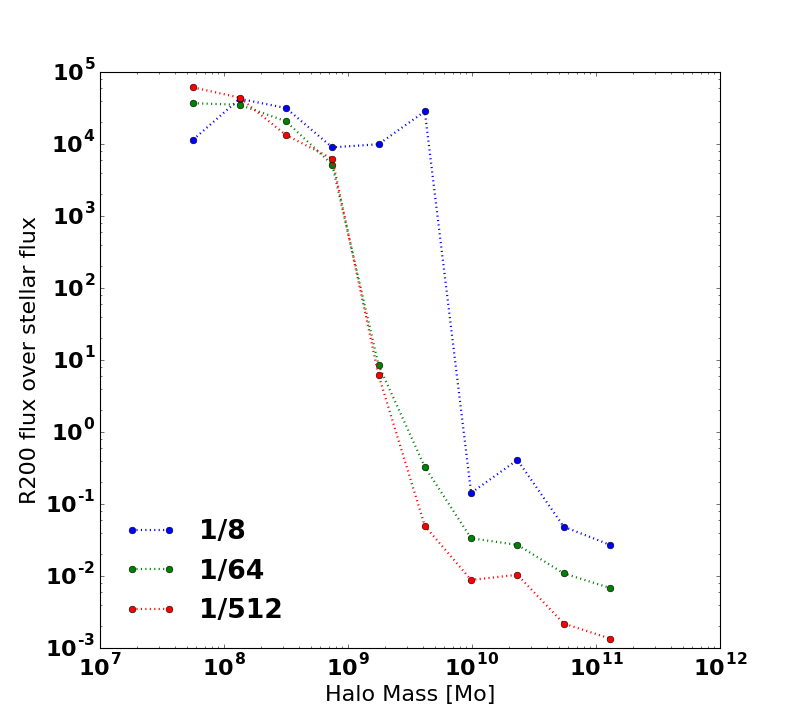

In [198]:
fig=plt.figure(figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)


info=run1.param.info
rad_scale=  (0.15**4) *info.unit_l**2 * info.unit_t/(365*24*3600)

Nbins=10

labels=["1/8","1/64","1/512"]
for i,cur_step in enumerate([run1.step_00017, run2.step_00017, run3.step_00021]):

    if i==0:
        mh=cur_step.fof.part_mass_fine
        Mbins=np.logspace(np.log10(np.min(mh)), np.log10(np.max(mh)), Nbins+1)
        _x=(Mbins[1:]+Mbins[:-1])/2
    
    cur_step.fof.get_luminosity_UV(cur_step)
    
    mask= cur_step.fof.star_flux_UV!=0
    mh=cur_step.fof.part_mass_fine[mask]
    w=cur_step.fof.mean_flux_rad_1_00[mask]*rad_scale/cur_step.fof.star_flux_UV[mask]
        
    thresh=0
    n1,_=np.histogram(mh[w>=thresh],bins=Mbins)
    rad1,_=np.histogram(mh[w>=thresh],bins=Mbins, weights=w[w>=thresh])
    plt.plot(_x,rad1/n1,'o:',lw=2, label=labels[i])
        
#     plt.plot(mh,w,'.')

plt.legend(frameon=False, loc=3 )
plt.xscale('log')
plt.yscale('log', nonposy='mask' )
plt.xlabel('Halo Mass [Mo]')
plt.ylabel('R200 flux over stellar flux')

In [68]:
print(run1.param.info.mass_res_star)
print(run2.param.info.mass_res_star)
print(run3.param.info.mass_res_star)

77112.0
9639.0
1204.875


In [79]:
cur_step = run1.step_00017

arg=np.argmax(cur_step.grid.field_d.data)
xc=cur_step.grid.x.data[arg]
yc=cur_step.grid.y.data[arg]
zc=cur_step.grid.z.data[arg]
print(zc)

reading grid_field.d
0.237305


<IPython.core.display.Javascript object>


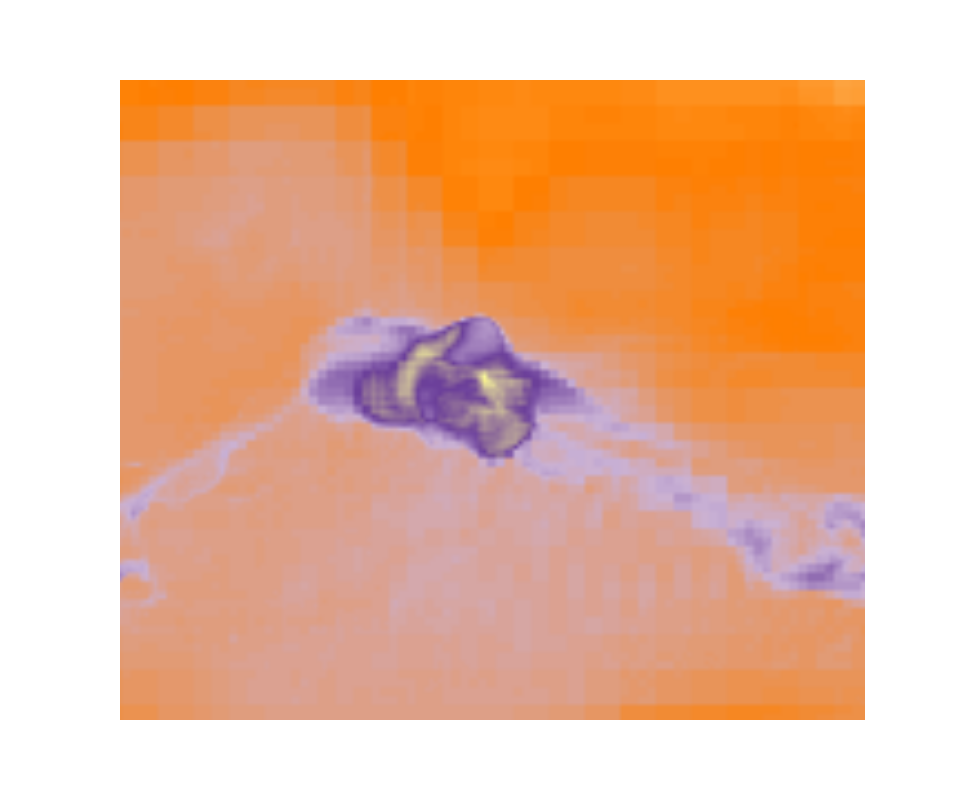

In [39]:

from mpl_toolkits.axes_grid1 import make_axes_locatable


# cur_step = run1.step_00017
# cur_step = run2.step_00017
cur_step = run3.step_00021

x=cur_step.grid.x.data
y=cur_step.grid.y.data
z=cur_step.grid.z.data
l=cur_step.grid.l.data
# d=cur_step.grid.xion.data
# d=cur_step.grid.field_d.data
d=cur_step.grid.rfield_temp.data

xmin=0.
xmax=1.
ymin=0.
ymax=1.
zmin=0.125
zmax=0.375


# xmin=0.25
# xmax=0.65
# ymin=0.45
# ymax=0.85


projection_level=11
map=grid.get_cube(x,y,z,l,d,projection_level,"2d",
                  xmin=xmin,xmax=xmax,
                  ymin=ymin,ymax=ymax,
                  zmin=zmin,zmax=zmax)

map=np.log10(map)
map=np.rollaxis(map, 0, 2)
map=np.roll(map, 2**10)

fig=plt.figure(2,figsize=(12,10))


plt.imshow(map,cmap="Paired",origin="lower",extent=(xmin,xmax,ymin,ymax), aspect='auto')

# plt.contour( map, np.log10([2e4]),extent=(xmin,xmax,ymin,ymax) )

# divider = make_axes_locatable(plt.gca())
# colorbar_ax = divider.append_axes("right", "2%", pad="10%")
# plt.colorbar()



# cur_step = run1.step_00017
# x=cur_step.star.x.data
# y=cur_step.star.y.data
# z=cur_step.star.z.data

# zmin=0.125
# zmax=0.375
# mask= (z>=zmin) & (z<zmax)

# plt.plot(y[mask],x[mask],'w.')

# plt.xlim(0.25,0.65)
# plt.ylim(0.45,0.85)





plt.axis("off")
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.savefig("fig.png", bbox_inches='tight', pad_inches=0)

In [131]:
print(map.shape)

(2048, 2048)


<IPython.core.display.Javascript object>


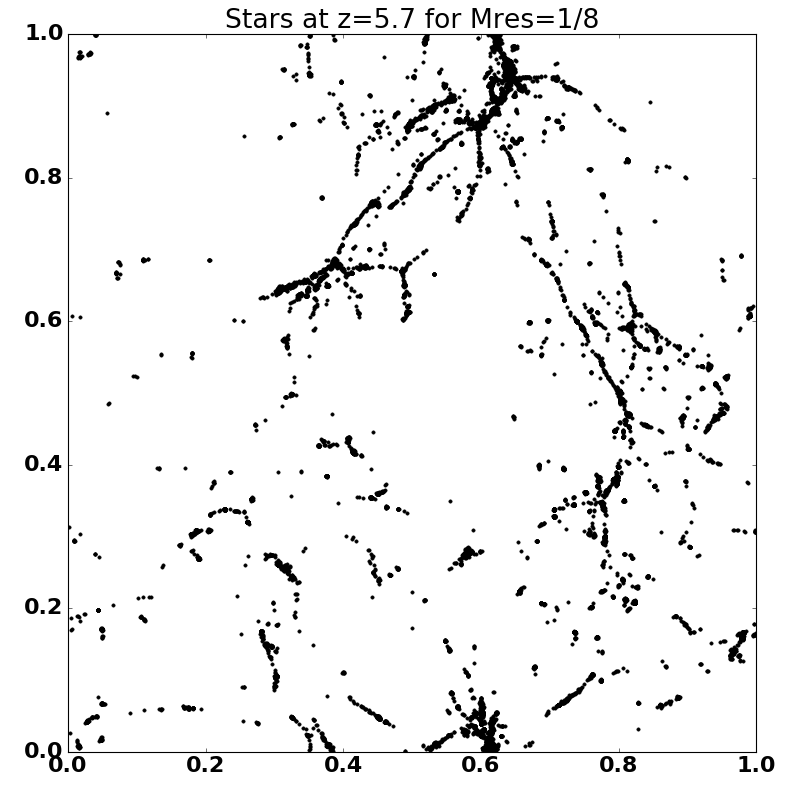

In [118]:
cur_step = run1.step_00017
# cur_step = run3.step_00021
fig=plt.figure(figsize=(10,10))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)


x=cur_step.star.x.data
y=cur_step.star.y.data
z=cur_step.star.z.data

zmin=0.125
zmax=0.375
mask= (z>=zmin) & (z<zmax)


plt.plot(y[mask],x[mask],'k.')
plt.tight_layout()
plt.title("Stars at z=5.7 for Mres=1/8")
plt.savefig("fig.png")

In [25]:
run4=io.Run(runset.runs[5].folder)
run5=io.Run(runset.runs[0].folder)
run6=io.Run(runset.runs[7].folder)

<IPython.core.display.Javascript object>


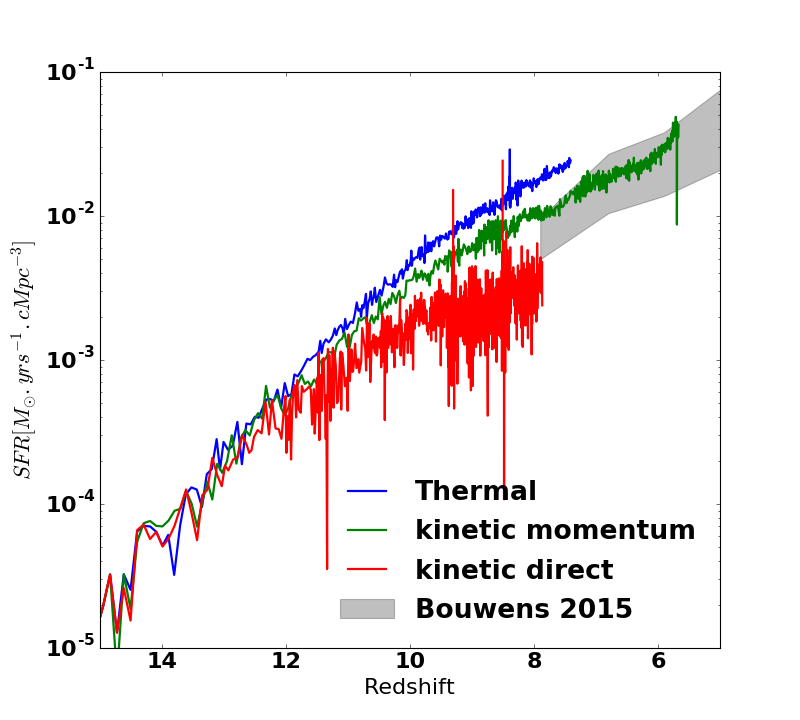

(1e-05, 0.1)

In [26]:
z1,sfr1=clean_sfr_restart(run4.param.avg.z,run4.param.avg.SFR)
z2,sfr2=clean_sfr_restart(run5.param.avg.z,run5.param.avg.SFR)
z3,sfr3=clean_sfr_restart(run6.param.avg.z,run6.param.avg.SFR)


fig=plt.figure(figsize=(10,9))
fig.patch.set_facecolor('#ffffff')
fig.patch.set_alpha(1)

plt.plot(z1[:-1],sfr1[:-1],lw=2, label="Thermal")
plt.plot(z2[:-1],sfr2[:-1],lw=2, label="kinetic momentum")
plt.plot(z3,sfr3,lw=2, label="kinetic direct")

x,y,_,z=observations.sfr1()
# plt.errorbar(x,y,yerr=z,fmt='ko',markersize=10)

arg=np.argsort(x)
x=x[arg][1::2]
y=y[arg][1::2]
zmin=z[0][arg][1::2]
zmax=z[1][arg][1::2]
plt.fill_between(x, y-zmin, y+zmax,  facecolor='k', alpha=0.25, label="Bouwens 2015")

x,y,_,z=observations.sfr2()
# plt.errorbar(x,y,yerr=z,fmt='ko',markersize=10)

# arg=np.argsort(x)
# x=x[arg][::1]
# y=y[arg][::1]
# zmin=z[0][arg][::1]
# zmax=z[1][arg][::1]
# plt.fill_between(x, y-zmin, y+zmax,facecolor='blue', alpha=0.5)


plt.legend(frameon=False, loc= 4)
plt.yscale("log", nonposy='mask')
plt.xlabel('Redshift')
plt.ylabel('$ SFR [ M_{\\odot}.yrs^{-1}.cMpc^{-3} ]$')

plt.xlim(15,5)
plt.ylim(1e-5,1e-1)
